<a href="https://colab.research.google.com/github/rvaldivia95/MEDSgo/blob/master/MEDSgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **1.- Download the Kaggle DataSet**

In [0]:
!pip install kaggle

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"raimundovb","key":"7f8e2800afe7469feb9049847de092fe"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle config path -p /content

mkdir: cannot create directory ‘/root/.kaggle’: File exists
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


In [0]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.24G/7.25G [02:47<00:00, 17.7MB/s]
100% 7.25G/7.25G [02:47<00:00, 46.5MB/s]


In [0]:
!unzip diabetic-retinopathy-resized.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44267_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44267_right.jpeg  
  inflating: resized_train_cropped/resized_

In [0]:
os.remove('diabetic-retinopathy-resized.zip') # borrar zip

In [0]:
!rm -r resized_train # borrar dataset que no se usa

In [0]:
os.remove('trainLabels.csv')

## **2.- Reorder the DataSet**

In [0]:
!mkdir dataset

In [0]:
cd dataset/

/content/dataset


In [0]:
!mkdir 0

In [0]:
!mkdir 1 

In [0]:
!mkdir 2

In [0]:
!mkdir 3

In [0]:
!mkdir 4

In [0]:
cd ../

/content


In [0]:
import os
import pandas as pd
import numpy as np
import shutil
import cv2


# abre el archivo csv donde se encuentran las imagenes y categorias
df_train = pd.read_csv('trainLabels_cropped.csv')
tf.keras.applications.densenet
# revisa todos los indices de trainLabels.csv.
df_train.head()

# tabla con los valores de cada imagen.
targets_series = pd.Series(df_train['level'])

# entrega una tabla con la posicion y el valor de este para cada valor.
one_hot = pd.get_dummies(targets_series, sparse = True)

#https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

for head in one_hot:

    for pos, source in enumerate(df_train['image']):
        
            img_path =  'resized_train_cropped/resized_train_cropped/'+source+'.jpeg'
            if type(cv2.imread(img_path))==type(None):
                continue

            elif df_train['level'][pos]==head:
                img_final = 'dataset/{}/{}.jpeg'.format(head, source) 

                # Move a file by renaming it's path
                os.rename(img_path, img_final)

            else:

                continue

In [0]:
!rm -r resized_train_cropped # borrar dataset que no se usa

# **3.- Trainung the model**

### For modeling, we took information from the following sources to give us a start for what already train algorithm we could use and what hyperparameters were the ones that had the best results. This way, the process of testing a model is much faster and with good results. Then could be possible to continue iterating to make the model better.

### The following investigations and papers were the ones used for the creation of the model:

[Automated Detection of Diabetic Retinopathy using Deep Learning](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961805/)

[Classification of Diabetic Retinopathy Images by Using Deep Learning Models](https://www.rchgate.net/publication/322978904_Classification_of_Diabetic_Retinopathy_Images_by_Using_Deep_Learning_Models)

[Transfer Learning based Detection of Diabetic Retinopathy from
Small Dataset](https://arxiv.org/pdf/1905.07203.pdf)

[Fastai- Kfold densenet201 outperforms](https://www.kaggle.com/hmnshu/fastai-kfold-densenet201-outperforms)

## **3.1.- Data Preparation (Data Augmentation)**

In [0]:
train_data_dir = 'dataset'


batch_size =  16
img_height = 256
img_width = 256
nb_epochs = 5
num_class = 5

# random padding with zeros, zoom, rolling and rotation
#Crop :- Images were randomly cropped to 85 − 95% of the original size
#Krizhevsky augmentation : Images were augmented by Krizhevsky color augmentation technique [20].
#Translation : Images were randomly shifted between −25 and 25 pixel
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 360,
                                   shear_range = 160,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   zoom_range= [1/1.3 , 1.3],
                                    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation') # set as validation data

Found 28089 images belonging to 5 classes.
Found 7019 images belonging to 5 classes.


## **3.2.-Modelo pre-entrenado sin "Transfer "Learning"**

## **3.3.- Model Training with Transfer Learning ( DenseNet201)**

In [0]:


base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height,img_width,3)))

x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
print('hola1')
#x = Dense(1024, activation='relu')(x)
print('hola2')
#x = Dense(1024, activation='relu')(x)
print('hola3')
predictions = Dense(num_class, activation='softmax')(x)
print('hola4')


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
print('hola5')
final_model = keras.Model(inputs=base_model.inputs, outputs=predictions) #create final model
print('hola6')
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "SGD", 
                    metrics=["accuracy"])
print('hola7')


fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, 
        validation_steps = validation_generator.samples // batch_size,
        epochs = nb_epochs)

hola1
hola2
hola3
hola4
hola5
hola6
hola7
Epoch 1/5
1755/1755 [==============================] - 1177s 670ms/step - loss: 34.1362 - acc: 0.5931 - val_loss: 20.6951 - val_acc: 0.6989
Epoch 2/5
1755/1755 [==============================] - 1145s 652ms/step - loss: 34.1218 - acc: 0.5992 - val_loss: 32.1127 - val_acc: 0.7051
Epoch 3/5
1755/1755 [==============================] - 1101s 627ms/step - loss: 33.8420 - acc: 0.6039 - val_loss: 27.0326 - val_acc: 0.7058
Epoch 4/5
1755/1755 [==============================] - 1130s 644ms/step - loss: 35.2028 - acc: 0.6034 - val_loss: 25.3108 - val_acc: 0.6562
Epoch 5/5
1755/1755 [==============================] - 1136s 647ms/step - loss: 35.1863 - acc: 0.6066 - val_loss: 35.2868 - val_acc: 0.7169


## **3.4.- Entrenamiento Modelo (w/o Transfer Learning)**

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
# https://www.tensorflow.org/api_docs/python/tf/nn/Ma

model = tf.keras.models.Sequential([
                                    
                                    tf.keras.layers.Conv2D(32,(4,4),activation='relu',strides=2, input_shape = (512,512,3), data_format='channels_first',),
                                    tf.keras.layers.Conv2D(32,(4,4), strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Conv2D(64,(4,4),strides=2,activation='relu'),
                                    tf.keras.layers.Conv2D(64,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Conv2D(128,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.Conv2D(128,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Conv2D(256,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Conv2D(384,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Conv2D(512,(4,4),strides=1,activation='relu'),
                                    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(1024, activation='relu'),
                                    tf.keras.layers.Dense(1024, activation='relu'),
                                    tf.keras.layers.Dense(5, activation='sigmoid')
                        
])

model.summary()

## **3.5.- Model Results**

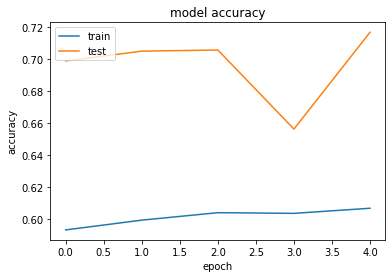

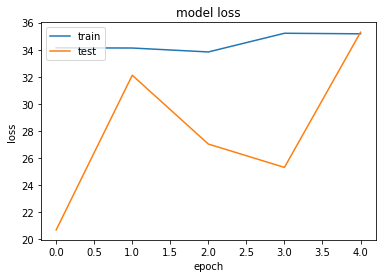

In [0]:
import matplotlib.pyplot as plt
#https://stackoverflow.com/questions/42689066/convolutional-neural-net-keras-val-acc-keyerror-acc
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **3.6.- Save the model**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
final_model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1KiZE3NczR_q-9DGZJKZeWcFuCGhVCq8v'})